In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

# ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
x_train.mean(), x_train.std()

(tensor(-9.9649e-10), tensor(1.0000))

In [5]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [7]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        CudaCallback,
       partial(AvgStatsCallback, accuracy),
       partial(BatchTransformXCallback, mnist_view)]

In [9]:
nfs = [8, 16, 32, 64, 64]

In [10]:
learn, run = get_learn_run(nfs, data, 0.5, conv_layer, cbs=cbfs)

In [11]:
%time run.fit(2, learn)

train: [1.2364951822916668, tensor(0.5838, device='cuda:0')]
valid: [0.345661083984375, tensor(0.8990, device='cuda:0')]
train: [0.21365442708333332, tensor(0.9351, device='cuda:0')]
valid: [0.2468989013671875, tensor(0.9244, device='cuda:0')]
CPU times: user 2.85 s, sys: 412 ms, total: 3.26 s
Wall time: 2.88 s


In [12]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [13]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [14]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr, cbs, opt_func)

In [15]:
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

In [16]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

In [17]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbfs)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

train: [0.250506640625, tensor(0.9211, device='cuda:0')]
valid: [0.2666080078125, tensor(0.9093, device='cuda:0')]


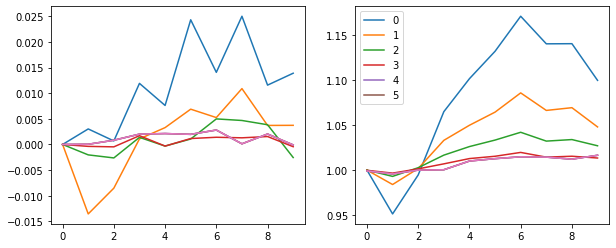

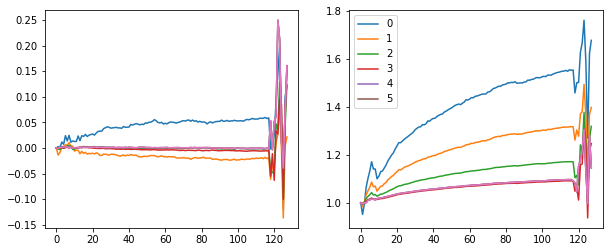

In [19]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss, = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

In [20]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbfs)

In [21]:
%time run.fit(3, learn)

train: [0.23168662109375, tensor(0.9285, device='cuda:0')]
valid: [0.72807822265625, tensor(0.7890, device='cuda:0')]
train: [0.08116021321614583, tensor(0.9745, device='cuda:0')]
valid: [1.141934765625, tensor(0.7732, device='cuda:0')]
train: [0.061000301106770835, tensor(0.9811, device='cuda:0')]
valid: [0.08454840087890625, tensor(0.9721, device='cuda:0')]
CPU times: user 4.34 s, sys: 684 ms, total: 5.02 s
Wall time: 4.43 s


In [22]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [23]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbfs)

In [24]:
%time run.fit(3, learn)

train: [0.20127804361979168, tensor(0.9374, device='cuda:0')]
valid: [0.1952510009765625, tensor(0.9389, device='cuda:0')]
train: [0.06288533528645833, tensor(0.9804, device='cuda:0')]
valid: [0.2620219482421875, tensor(0.9168, device='cuda:0')]
train: [0.044371891276041665, tensor(0.9861, device='cuda:0')]
valid: [0.04675069580078125, tensor(0.9839, device='cuda:0')]
CPU times: user 3.97 s, sys: 623 ms, total: 4.59 s
Wall time: 3.99 s


In [25]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [26]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [27]:
run.fit(8, learn)

train: [0.21656790364583334, tensor(0.9344, device='cuda:0')]
valid: [0.6639154296875, tensor(0.8461, device='cuda:0')]
train: [0.07833378092447917, tensor(0.9762, device='cuda:0')]
valid: [0.664198046875, tensor(0.8604, device='cuda:0')]
train: [0.06516867268880208, tensor(0.9797, device='cuda:0')]
valid: [0.20845068359375, tensor(0.9396, device='cuda:0')]
train: [0.03388302205403646, tensor(0.9893, device='cuda:0')]
valid: [0.04253231201171875, tensor(0.9861, device='cuda:0')]
train: [0.020250750732421875, tensor(0.9938, device='cuda:0')]
valid: [0.03288491516113281, tensor(0.9894, device='cuda:0')]
train: [0.01224951171875, tensor(0.9965, device='cuda:0')]
valid: [0.031375924682617184, tensor(0.9905, device='cuda:0')]
train: [0.007890040588378906, tensor(0.9982, device='cuda:0')]
valid: [0.0307600341796875, tensor(0.9906, device='cuda:0')]
train: [0.005407067362467448, tensor(0.9991, device='cuda:0')]
valid: [0.029102413940429686, tensor(0.9910, device='cuda:0')]


# More norms

## Layer norms

In [29]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.add

In [30]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [34]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbfs)

In [35]:
%time run.fit(3, learn)

train: [nan, tensor(0.1291, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 6.14 s, sys: 632 ms, total: 6.77 s
Wall time: 6.17 s


# Instance Norm

In [39]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var((2,3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.adds

In [40]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [41]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbfs)

In [42]:
run.fit(3, learn)

train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]


# Fix small batch sizes

In [45]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [46]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [47]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [48]:
%time run.fit(1, learn)

train: [2.3072236979166667, tensor(0.1970, device='cuda:0')]
valid: [4773628.3136, tensor(0.3419, device='cuda:0')]
CPU times: user 2min, sys: 6.9 s, total: 2min 7s
Wall time: 2min 5s


In [51]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
     
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
    
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        means = sums / c
        vars = (sqrs/c).sub_(means*means)
        
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [52]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [53]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [54]:
%time run.fit(1, learn)

train: [0.37787610677083333, tensor(0.9003, device='cuda:0')]
valid: [0.1390560546875, tensor(0.9625, device='cuda:0')]
CPU times: user 5min 45s, sys: 39.6 s, total: 6min 24s
Wall time: 6min 22s


In [55]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [56]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [57]:
%time run.fit(1, learn)

train: [0.16644539388020832, tensor(0.9470, device='cuda:0')]
valid: [0.0775959228515625, tensor(0.9820, device='cuda:0')]
CPU times: user 23.2 s, sys: 2.84 s, total: 26.1 s
Wall time: 25.8 s
